# Training data selection for ML regression
This notebook reports regression experiments showing that the selection of the training set impacts the prediction performance of ML regression models. Additionally, we present experiments indicating that:

-Using the Farthest Point Sampling (FPS) method to select training samples can reduce the maximum prediction error (MAXAE). This is particularly beneficial in the low training data regime (when the training set contains less than 5% of the available data points).

-Selecting training sets using Density Aware Farthest Point Sampling (DAFPS) can reduce the mean absolute error (MAE) of ML regression models. This is especially advantageous in the medium training data regimen (when the training set contains between 5% and 25% of the available data points).



In [1]:
#%pip install PAsampling
import numpy as np
from tqdm import tqdm
import pandas as pd
import h5py
import random

from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, pairwise_distances
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

from PAsampling import *
from utils_tutorial import generate_lineplots


# 1. Download and Read Data
The `DataLoader` class is used to download, read, and preprocess datasets. It takes the path to the folder where the datasets will be downloaded. Once you create an object of the `DataLoader` class, you can use methods like `QM7_dataset` and  the`Power_Grid_dataset` to download and preprocess the respective datasets. These methods return a data feature matrix `x` and associated labels `y`. You can also modify the `DataLoader` class to include your own dataset. Using the `DataLoader` class provides a structured and efficient way to interact with your dataset and build a machine learning pipeline for experiments.

In [2]:
datasets =  DataLoader('./data')
x, y = datasets.QM7_dataset()
print('Shape data matrix:', x.shape)

Download successful. Data saved to ./data/data_qm7/qm7.mat
Shape data matrix: (7165, 276)


# 2. Data Selection
The `DataSelector` function splits the data into training and testing sets using various sampling strategies. It takes the data matrix `x` (with shape `(n_samples, n_features)`), the path to save the h5py file containing the data splits, a list of sampling strategies, the training set sizes, and the initial conditions. The initial conditions are the indices of the initially selected points for greedy algorithms and different seeds for the others. The sampling strategies are from the PAsampling library. Using the `DataSelector` function helps to efficiently select samples according to different strategies, training set sizes, and initialization parameters by running a single function. It is a useful tool for building a machine learning pipeline to run experiments in bulk.

In [3]:
seed = 123  # Set seed for reproducibility
random.seed(seed)
initial_conditions =  random.sample(list(range(len(x))), 5)

trainig_set_sizes =  [int((len(x)/100)*c) for c in [ 5, 10, 20, 25]]
strategies =  ['Twinning', 'FPS', 'RDM', 'FacilityLocation', 'k-medoids++', 'DAFPS']
DataSelector(x,  "Passive_sampling_QM7_DAFPS" , strategies, trainig_set_sizes, initial_conditions, ratios=[20, 10, 5, 4], mu=0)

DAFPS 


5it [00:33,  6.77s/it]


FPS


5it [00:22,  4.51s/it]


RDM


100%|██████████| 5/5 [00:00<00:00, 69.39it/s]


k-medoids++


5it [00:20,  4.19s/it]


FacilityLocation


5it [00:19,  3.98s/it]


Twinning


5it [00:32,  6.54s/it]


# 3. Molecular Property Prediction: KRR with Gaussian Kernel
## 3.1 Hyperparameters grid-search on random data
We perform hyperparameter search for the KRR using cross validation on randomly selected elements.

In [4]:
warnings.filterwarnings("ignore") #To ignore warnings related to singular matrices. Remove this line to see the warnings!!
f = h5py.File("Passive_sampling_QM7_DAFPS", "r")
hyperparameters = {'num_selected' : [],'alpha':  [], 'gamma' : []}

for size in tqdm(trainig_set_sizes):

    train_tags = f['RDM']['train_Initialize_1'][f'selected_{size}'][:]
    
    krr = KernelRidge()
    alpha = np.logspace(-6, -1, 6)
    gamma = np.logspace(-6, -1, 6)
    
    #Parameters grid
    parameters = { 'alpha':alpha, 'kernel':['rbf'], 'gamma':gamma}

    #Cross Validation
    clf = GridSearchCV(krr, parameters, cv=5, scoring = 'neg_mean_absolute_error',  verbose=0, n_jobs = 1)
    clf.fit(x[train_tags,:],y[train_tags])
    
    #Select best parameters
    alpha = clf.best_params_['alpha'] 
    gamma = clf.best_params_['gamma'] 
    
    #Save best parameters
    hyperparameters['num_selected'].append(size)
    hyperparameters['alpha'].append(alpha)
    hyperparameters['gamma'].append(gamma)

f.close()
hyperparameters_df = pd.DataFrame(data=hyperparameters)

100%|██████████| 4/4 [16:19<00:00, 244.98s/it]


# 3.2 Regression task


In [5]:
f = h5py.File("Passive_sampling_QM7_DAFPS", "r")
alpha = hyperparameters_df['alpha'].mean()
gamma = hyperparameters_df['gamma'].mean()

d_a = {'strategy' : [], 'initialization' : [], 'num_selected' : [],  'MAE':  [],  'RMSE' : [], 'MAXAE' : []}

for size in tqdm(trainig_set_sizes):
    for ss in strategies:
        for init in [1,2,3,4,5]:
                
                    #Load indeces training and test set   
                    idx_train = f[ss][f'train_Initialize_{init}'][f'selected_{size}'][:]
                    idx_test = f[ss][f'test_Initialize_{init}'][f'selected_{size}'][:]
                
                    #Regression
                    krr = KernelRidge(alpha=alpha, kernel= 'rbf', gamma =gamma )
                    krr.fit(x[idx_train,:], y[idx_train]) 
      
                    #Prediction and errors computation
                    ypred = krr.predict(X=x[idx_test,:])
                    MAE = mean_absolute_error(y[idx_test], ypred) 
                    MSE =mean_squared_error(y[idx_test], ypred)
                    MAXAE =  max_error(y[idx_test], ypred)
                    
                    # Save results in dictionary
                    d_a['strategy'].append(ss)
                    d_a['initialization'].append(init)
                    d_a['num_selected'].append(size)
                    d_a['MAE'].append(MAE)
                    d_a['RMSE'].append(np.sqrt(MSE))
                    d_a['MAXAE'].append(MAXAE)

df = pd.DataFrame(data=d_a)
df.to_csv('test_reuslt.csv')
f.close()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:20<00:00,  5.08s/it]


# 3.2.1 Plot results regression



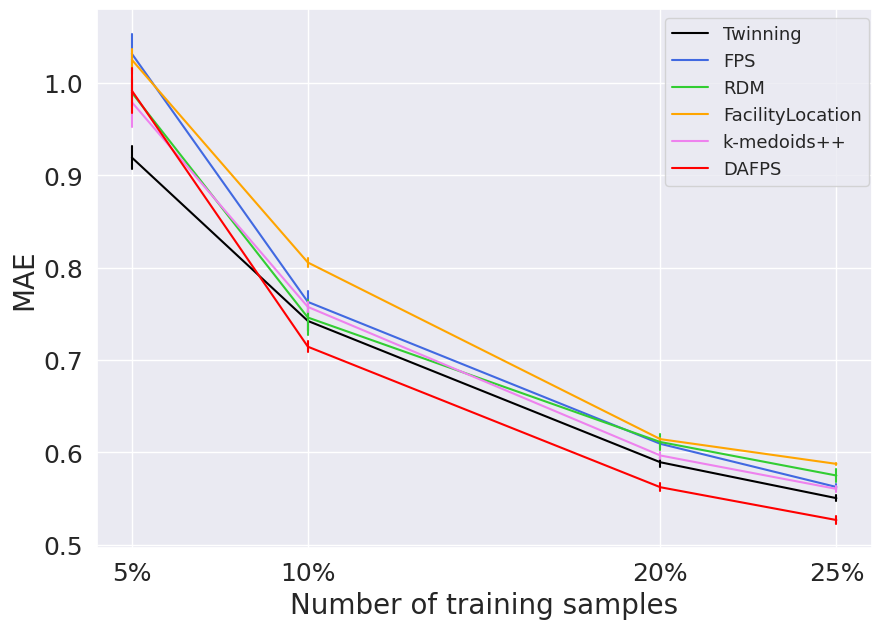

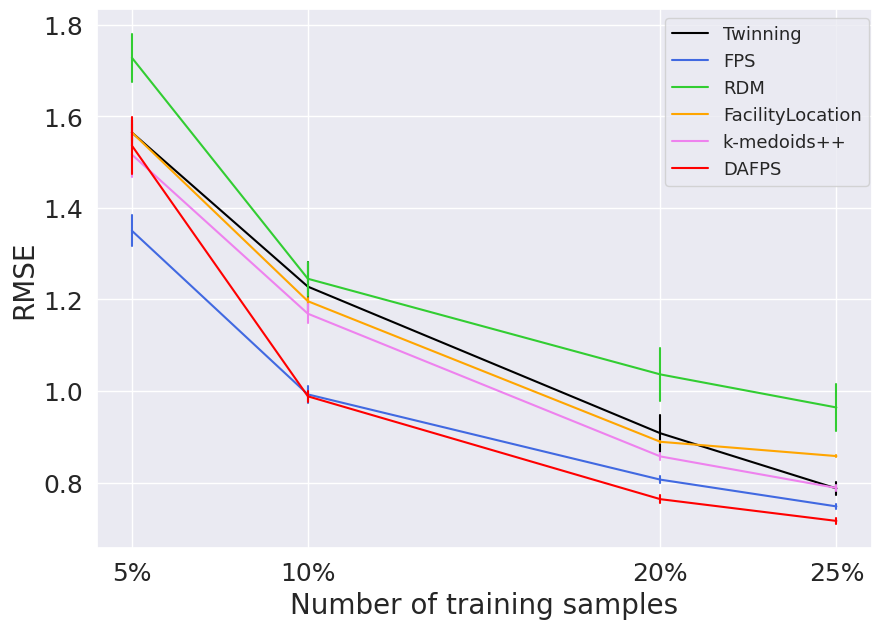

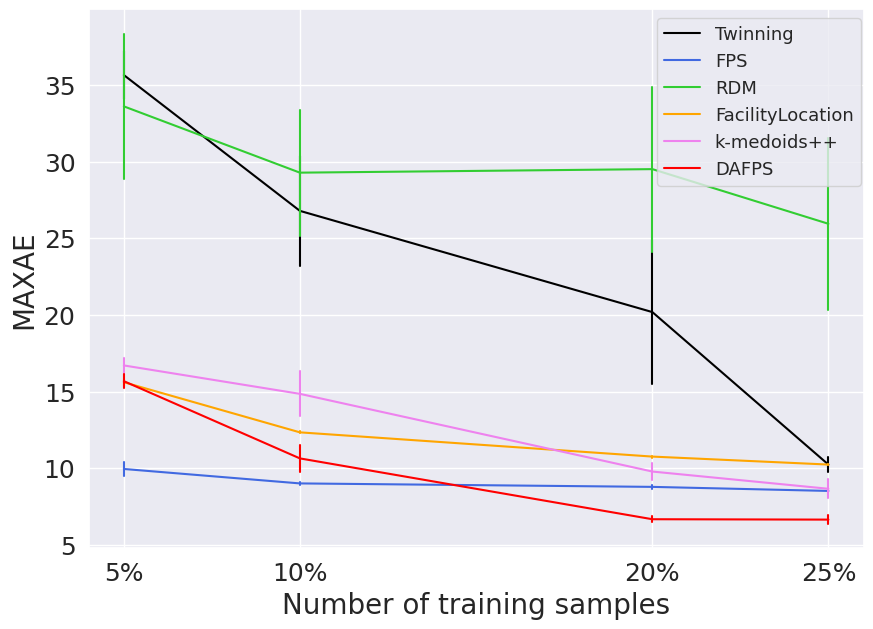

In [6]:
df = pd.read_csv('test_reuslt.csv')
strategies =  [ 'Twinning', 'FPS', 'RDM', 'FacilityLocation', 'k-medoids++',  'DAFPS']
generate_lineplots('QM7', df,  given_strategies = strategies)

The results in the figure show that on the QM7 dataset, the DA-FPS method leads to better average prediction performance of the KRR model in terms of root mean squared error and mean absolute error for training set sizes larger than 5% of the available data points. Moreover, for training set sizes smaller than 10% (less than 700 points), FPS significantly reduces the maximum prediction error. This indicates that for smaller training set sizes, increasing the diversity of the selected samples can improve the robustness of the predictions.